# Plot along-slope velocity along the 1000 m isobath for easterly simulations

The data are calculated and saved in 'calc_ASC_1000m_isobath.ipynb' and are a climatology of the last 5 years of the simulation (2160-2164).

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import xgcm
import xarray.ufuncs as xu

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40465 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-58)

Bathymetry

In [4]:
# topography data for plotting (on u-grid):
hu = cc.querying.getvar(control,'hu' , master_session,n=1)
land_mask = np.squeeze(hu.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

hu = hu.sel(yu_ocean=lat_slice)

fontsize=16

Along-slope velocity along 1000m isobath

In [5]:
# Load dataset
file_name = 'Antarctic_slope_1000m_contour_con.npz'
data_con  = np.load(file_name)
file_name = 'Antarctic_slope_1000m_contour_up.npz'
data_up   = np.load(file_name)
file_name = 'Antarctic_slope_1000m_contour_down.npz'
data_down = np.load(file_name)
# Velocity
u_con      = data_con['u_along_contour']
u_btr_con  = data_con['u_btr_contour']
u_up       = data_up['u_along_contour']
u_btr_up   = data_up['u_btr_contour']
u_down     = data_down['u_along_contour']
u_btr_down = data_down['u_btr_contour']
# Other info
st_ocean  = data_con['st_ocean']
lat_along_contour = data_con['lat_along_contour']
lon_along_contour = data_con['lon_along_contour']
distance  = data_con['distance_along_contour']
thickness = data_con['thickness_contour']
# Print available info in dataset
data_con.files

['u_along_contour',
 'u_btr_contour',
 'lat_along_contour',
 'lon_along_contour',
 'num_points',
 'distance_along_contour',
 'st_ocean',
 'thickness_contour']

In [6]:
distance[-1] = distance[-2]+1

Plot velocity along 1000 m isobath

In [7]:
scale_max = 0.05
ft_size   = 16
title_name = ['u_along control', 'u_along change for easterlies increase', 'u_along change for easterlies decrease']

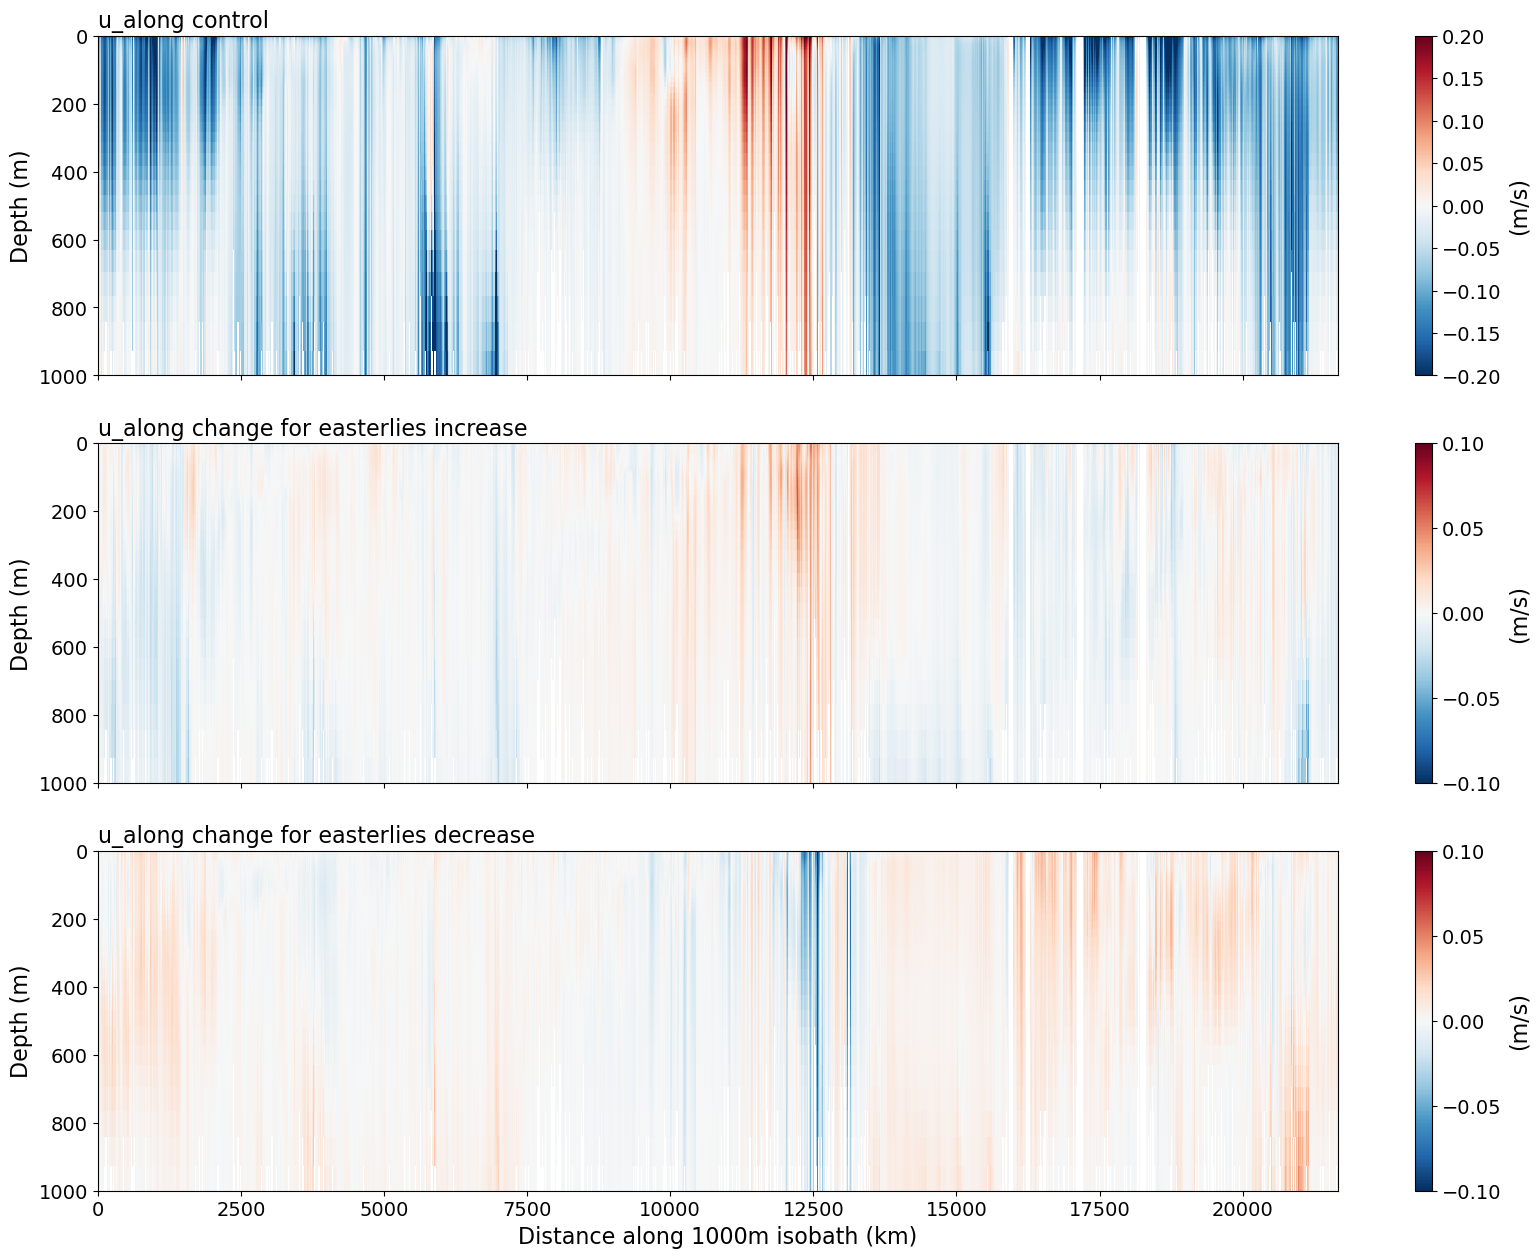

In [41]:
fig = plt.figure(figsize=(20,15))

for ii in range(3):
    ax = plt.subplot(3, 1, 1+ii)
    if ii == 0:
        plt.pcolormesh(distance, st_ocean, u_con.mean(axis=0), vmin=-(4*scale_max), vmax=4*scale_max, cmap='RdBu_r')
        ax.tick_params(labelbottom=False)
    elif ii == 1:
        plt.pcolormesh(distance, st_ocean, u_up.mean(axis=0) - u_con.mean(axis=0), vmin=-(2*scale_max), vmax=2*scale_max, cmap='RdBu_r')
        ax.tick_params(labelbottom=False)
    elif ii == 2:
        plt.pcolormesh(distance, st_ocean, u_down.mean(axis=0) - u_con.mean(axis=0), vmin=-(2*scale_max), vmax=2*scale_max, cmap='RdBu_r')
        plt.xlabel('Distance along 1000m isobath (km)', fontsize=ft_size)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ft_size-2)
    cbar.set_ticks(np.arange(-4*scale_max, 4*scale_max+scale_max, scale_max))
    cbar.set_label('(m/s)', fontsize=ft_size)
    plt.title(title_name[ii], fontsize=ft_size, loc='left')
    ax.tick_params(labelsize=ft_size-2)
    plt.ylim(1000, 0)
    plt.ylabel('Depth (m)', fontsize=ft_size)
    
save_fig = 0
if save_fig == 1:
    fig_name = 'Fig_ASC_1000m_contour_easterlies_pert.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Plot upper 500 m (vertical average) for control and the two perturbations - compare with the map (here it looks like the response is symmetrical and in the map it seems to be unsymmetrical).

In [8]:
u_con_500m  = np.sum(u_con.mean(axis=0)[:40,:] * thickness[:40,:], axis=0) / np.sum(thickness[:40,:], axis=0)
u_up_500m   = np.sum(u_up.mean(axis=0)[:40,:] * thickness[:40,:], axis=0) / np.sum(thickness[:40,:], axis=0)
u_down_500m = np.sum(u_down.mean(axis=0)[:40,:] * thickness[:40,:], axis=0) / np.sum(thickness[:40,:], axis=0)

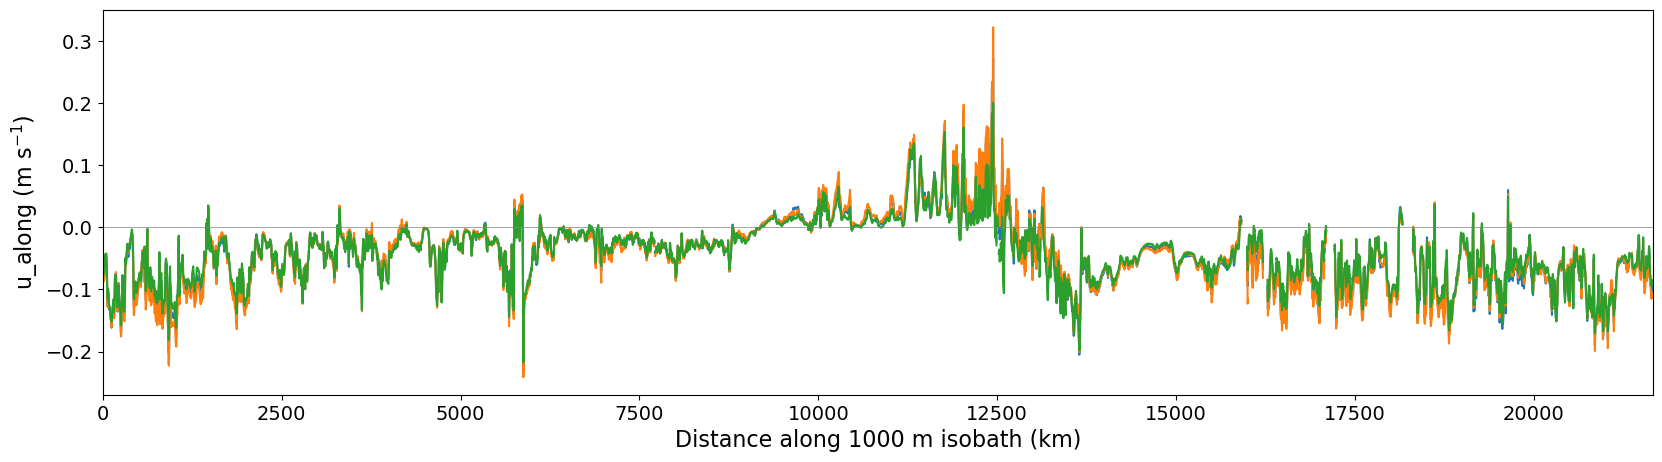

In [43]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
plt.plot(distance, u_con_500m, color='C0')
plt.plot(distance, u_up_500m, color='C1')
plt.plot(distance, u_down_500m, color='C2')
plt.axhline(0, color='0.5', linewidth=0.5)
plt.xlim(distance[0], distance[-2])
plt.xlabel('Distance along 1000 m isobath (km)', fontsize=ft_size)
plt.ylabel('u_along (m s$^{-1}$)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size-2)

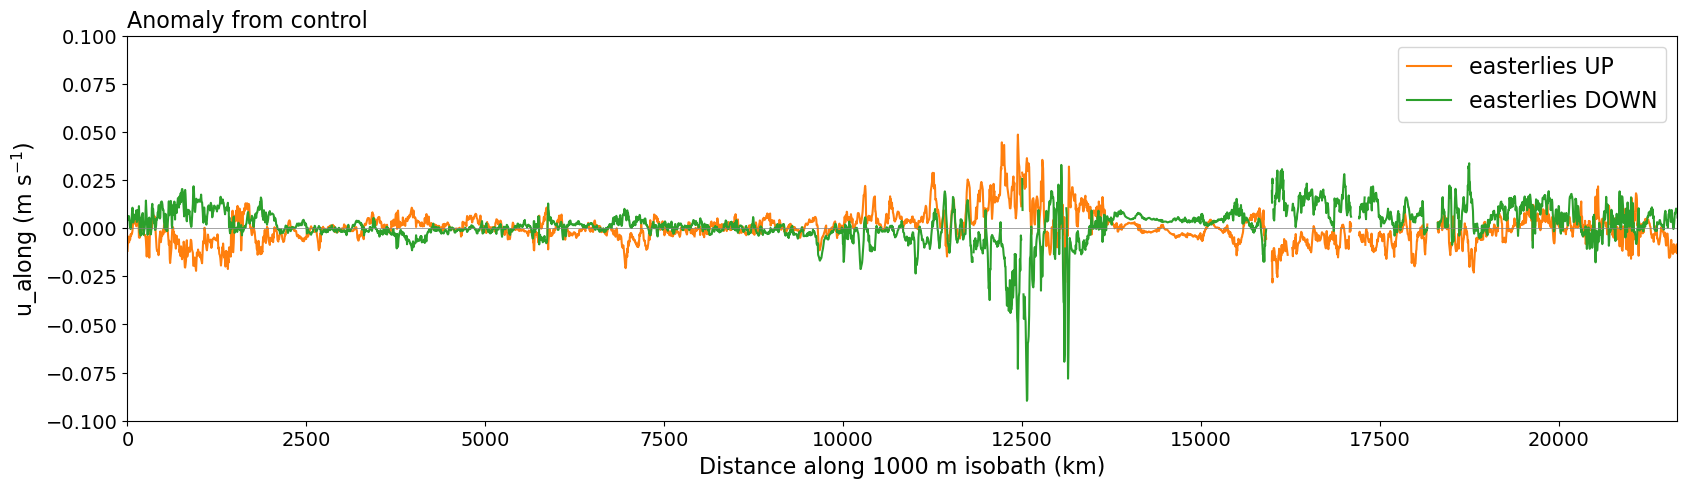

In [18]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
plt.title('Anomaly from control', fontsize=ft_size, loc='left')
plt.plot(distance, u_up_500m - u_con_500m, color='C1', label='easterlies UP')
plt.plot(distance, u_down_500m - u_con_500m, color='C2', label='easterlies DOWN')
plt.axhline(0, color='0.5', linewidth=0.5)
plt.xlim(distance[0], distance[-2])
plt.ylim(-0.1, 0.1)
plt.xlabel('Distance along 1000 m isobath (km)', fontsize=ft_size)
plt.ylabel('u_along (m s$^{-1}$)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size-2)
plt.legend(fontsize=ft_size)

save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_ASC_1000m_contour_easterlies_pert_upper500m.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Along-slope velocity along 1000 m isobath for year 1 of perturbation

In [20]:
# Load data
# Load dataset
file_name = 'Antarctic_slope_1000m_contour_year1_con.npz'
data_con  = np.load(file_name)
file_name = 'Antarctic_slope_1000m_contour_year1_up.npz'
data_up   = np.load(file_name)
file_name = 'Antarctic_slope_1000m_contour_year1_down.npz'
data_down = np.load(file_name)
# Velocity
u_year1_con      = data_con['u_along_contour']
u_btr_year1_con  = data_con['u_btr_contour']
u_year1_up       = data_up['u_along_contour']
u_btr_year1_up   = data_up['u_btr_contour']
u_year1_down     = data_down['u_along_contour']
u_btr_year1_down = data_down['u_btr_contour']

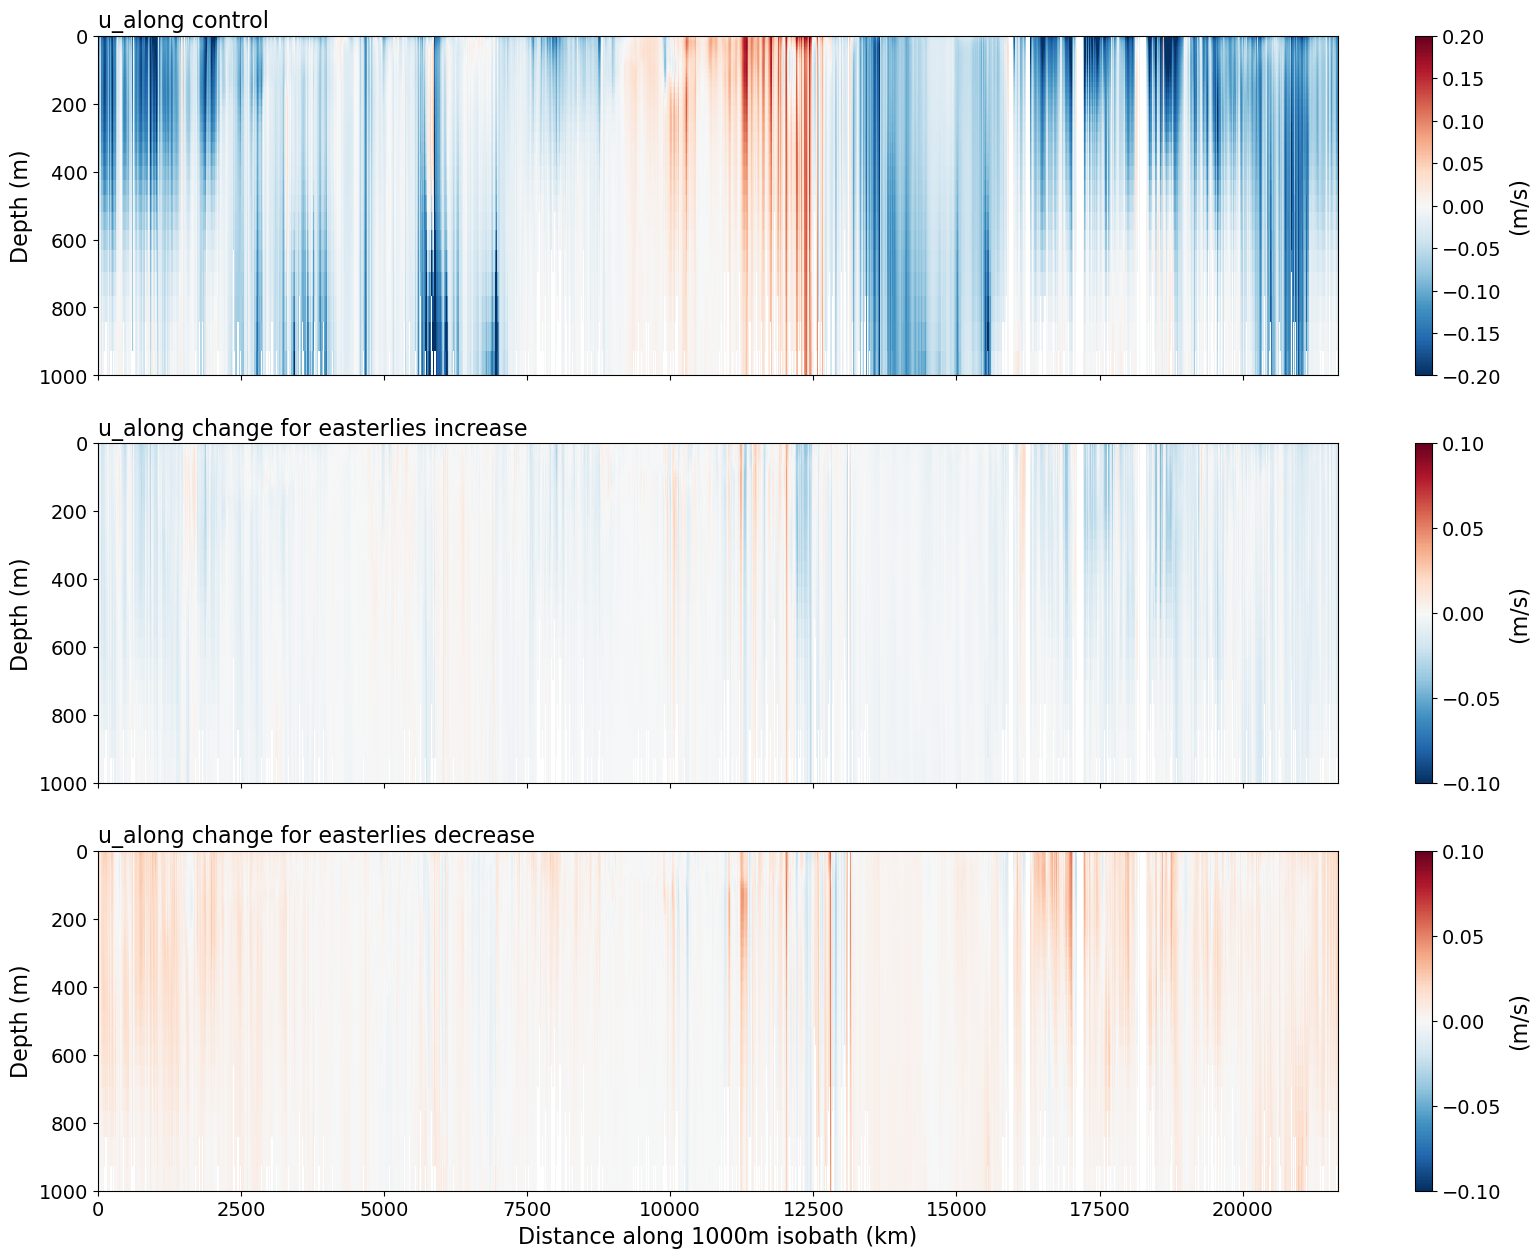

In [26]:
fig = plt.figure(figsize=(20,15))

for ii in range(3):
    ax = plt.subplot(3, 1, 1+ii)
    if ii == 0:
        plt.pcolormesh(distance, st_ocean, u_year1_con.mean(axis=0), vmin=-(4*scale_max), vmax=4*scale_max, cmap='RdBu_r')
        ax.tick_params(labelbottom=False)
    elif ii == 1:
        plt.pcolormesh(distance, st_ocean, u_year1_up.mean(axis=0) - u_year1_con.mean(axis=0), vmin=-(2*scale_max), vmax=2*scale_max, cmap='RdBu_r')
        ax.tick_params(labelbottom=False)
    elif ii == 2:
        plt.pcolormesh(distance, st_ocean, u_year1_down.mean(axis=0) - u_year1_con.mean(axis=0), vmin=-(2*scale_max), vmax=2*scale_max, cmap='RdBu_r')
        plt.xlabel('Distance along 1000m isobath (km)', fontsize=ft_size)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ft_size-2)
    cbar.set_ticks(np.arange(-4*scale_max, 4*scale_max+scale_max, scale_max))
    cbar.set_label('(m/s)', fontsize=ft_size)
    plt.title(title_name[ii], fontsize=ft_size, loc='left')
    ax.tick_params(labelsize=ft_size-2)
    plt.ylim(1000, 0)
    plt.ylabel('Depth (m)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_ASC_1000m_contour_easterlies_pert_year1.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

And the vertical average for the upper 500 m

In [23]:
u_year1_con_500m  = np.sum(u_year1_con.mean(axis=0)[:40,:] * thickness[:40,:], axis=0) / np.sum(thickness[:40,:], axis=0)
u_year1_up_500m   = np.sum(u_year1_up.mean(axis=0)[:40,:] * thickness[:40,:], axis=0) / np.sum(thickness[:40,:], axis=0)
u_year1_down_500m = np.sum(u_year1_down.mean(axis=0)[:40,:] * thickness[:40,:], axis=0) / np.sum(thickness[:40,:], axis=0)

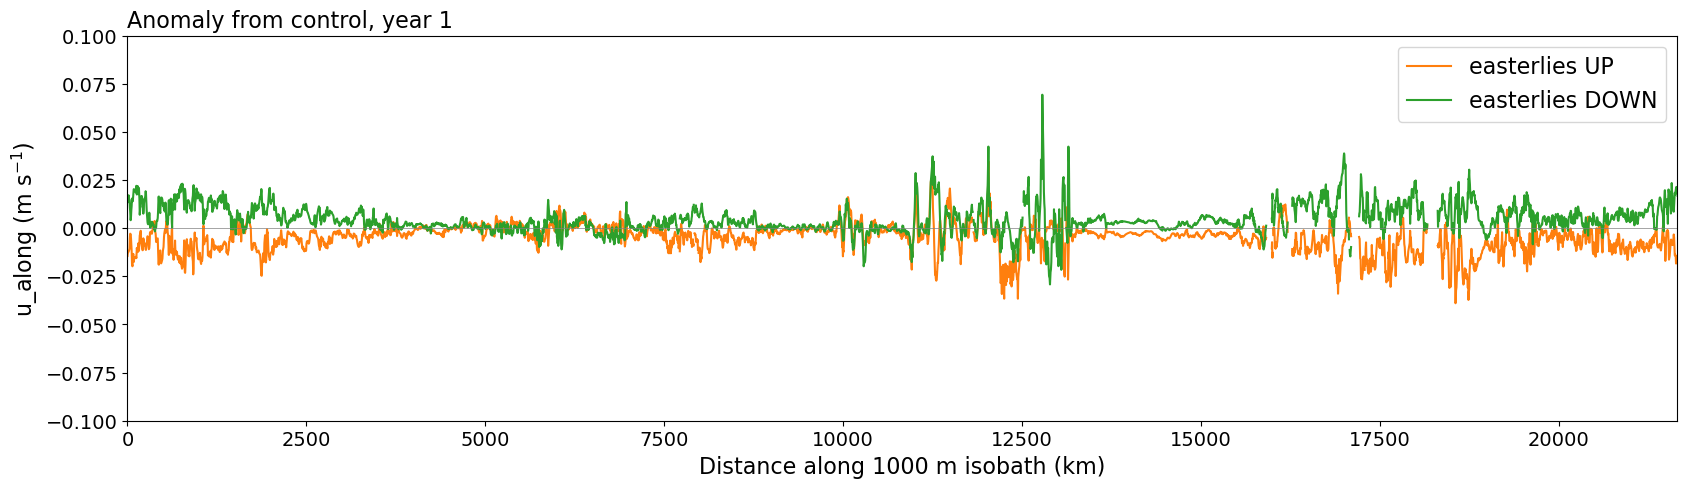

In [25]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
plt.title('Anomaly from control, year 1', fontsize=ft_size, loc='left')
plt.plot(distance, u_year1_up_500m - u_year1_con_500m, color='C1', label='easterlies UP')
plt.plot(distance, u_year1_down_500m - u_year1_con_500m, color='C2', label='easterlies DOWN')
plt.axhline(0, color='0.5', linewidth=0.5)
plt.xlim(distance[0], distance[-2])
plt.ylim(-0.1, 0.1)
plt.xlabel('Distance along 1000 m isobath (km)', fontsize=ft_size)
plt.ylabel('u_along (m s$^{-1}$)', fontsize=ft_size)
ax.tick_params(labelsize=ft_size-2)
plt.legend(fontsize=ft_size)

save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_ASC_1000m_contour_easterlies_pert_upper500m_year1.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')